In [66]:
import numpy as np
import torch
from transformers import Qwen2ForCausalLM
from transformers.models.qwen2.modeling_qwen2 import apply_rotary_pos_emb as hf_apply_rotary_pos_emb
import os

os.environ['HTTP_PROXY'] = 'http://localhost:7890'
os.environ['HTTPS_PROXY'] = 'http://localhost:7890'

# Analyze q/k distribution

In [3]:
k = np.fromfile('../data/k.bin', dtype=np.float32).reshape(-1, 128)
q = np.fromfile('../data/q.bin', dtype=np.float32).reshape(-1, 128)
(k.shape, q.shape)

((128000, 128), (128000, 128))

In [7]:
k_l2 = np.linalg.norm(k, axis=1)
q_l2 = np.linalg.norm(q, axis=1)
print(k_l2.mean(), k_l2.std())
print(q_l2.mean(), q_l2.std())

23.511227 2.3082576
26.730055 2.0312736


In [ ]:
k_norm = k / k_l2[:, None]
q_norm = q / q_l2[:, None]
k_norm.tofile('../data/k_norm.bin')
q_norm.tofile('../data/q_norm.bin')

In [ ]:
R = 64
k_aug = np.concatenate([k, np.sqrt(R**2 - k_l2**2)[:, None]], axis=1)
q_aug = np.concatenate([q, np.zeros((q.shape[0], 1))], axis=1)
k_aug.tofile('../data/k_aug.bin')
q_aug.tofile('../data/q_aug.bin')

64.0 1.8832351e-06


# Compare QK

In [13]:
bsz = 1
seq_len = 127284
head_dim = 128
num_kv_heads = 4

In [ ]:
k_gt = torch.load('../.data/qkvdump/layer_27_k.pt').reshape(bsz, seq_len, num_kv_heads, head_dim)[:, 128:-128, :, :].contiguous()
k = torch.from_numpy(np.load('/tmp/diffcache_prefix/Qwen/Qwen2.5-7B-Instruct/c20251117_020025/qk/k_m00l027.npy')).permute(0, 2, 1, 3).contiguous()
k.shape, k_gt.shape

(torch.Size([1, 127028, 4, 128]), torch.Size([1, 127028, 4, 128]))

In [71]:
print("k shape:", k.shape)
print("k_gt shape:", k_gt.shape)
print("dtypes:", k.dtype, k_gt.dtype)

diff = (k - k_gt).abs()
print("max:", diff.max().item())
print("mean:", diff.mean().item())
print("median:", diff.median().item())

k shape: torch.Size([1, 127028, 4, 128])
k_gt shape: torch.Size([1, 127028, 4, 128])
dtypes: torch.float32 torch.bfloat16
max: 14.46875
mean: 0.06324608623981476
median: 0.03125


In [72]:
diff = (k - k_gt).abs()
idx = diff.view(-1).argmax()
b, t, h, d = torch.unravel_index(idx, diff.shape)

print("worst index: batch, token, head, dim =", b.item(), t.item(), h.item(), d.item())
print("k     at that index:", k[b, t, h, d].item())
print("k_gt  at that index:", k_gt[b, t, h, d].item())
print("diff at that index:", diff[b, t, h, d].item())

print("k vector snippet:", k[b, t, h, :8])
print("k_gt vector snippet:", k_gt[b, t, h, :8])
print("diff snippet:", diff[b, t, h, :8])

worst index: batch, token, head, dim = 0 120477 0 56
k     at that index: 7.625
k_gt  at that index: -6.84375
diff at that index: 14.46875
k vector snippet: tensor([-0.2695,  1.0703, -0.2461, -0.2637,  0.8828, -0.3867,  1.0703,  0.5742])
k_gt vector snippet: tensor([-0.8242,  1.1562,  0.3340, -0.5391,  1.1406, -0.7070,  1.1875,  0.2891],
       dtype=torch.bfloat16)
diff snippet: tensor([0.5547, 0.0859, 0.5801, 0.2754, 0.2578, 0.3203, 0.1172, 0.2852])


In [74]:
diff = (k - k_gt).abs()
bsz, seqlen, nheads, d = diff.shape

for h in range(nheads):
    dh = diff[0, :, h, :]  # assume batch 0
    print(
        f"head {h:02d}: max={dh.max().item():.4f}, mean={dh.mean().item():.4f}"
    )

head 00: max=14.4688, mean=0.0639
head 01: max=11.1328, mean=0.0631
head 02: max=10.1562, mean=0.0630
head 03: max=11.7070, mean=0.0629


In [73]:
window = 1024

diff_head0 = diff[0, :, 0, :]  # just head 0 for demo

print("first window max:", diff_head0[:window].max().item())
print("last  window max:", diff_head0[-window:].max().item())

first window max: 4.125
last  window max: 13.53125


In [59]:
del k_gt, k
torch.cuda.empty_cache()

# Analyze hidden layer

In [27]:
gt_q, gt_k = torch.load('/home/ubuntu/projects/DiffCache/.data/gt.pt')
gt_q = gt_q.permute(0, 2, 1, 3).contiguous()
gt_k = gt_k.permute(0, 2, 1, 3).contiguous()
dc_q, dc_k = torch.load('/home/ubuntu/projects/DiffCache/.data/diffcache_out.pt')
dc_q = dc_q.view_as(gt_q)
dc_k = dc_k.view_as(gt_k)
gt_k.shape, dc_k.shape

(torch.Size([1, 127284, 4, 128]), torch.Size([1, 127284, 4, 128]))

import matplotlib.pyplot as plt

In [42]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Windowed mean per-token max abs error')

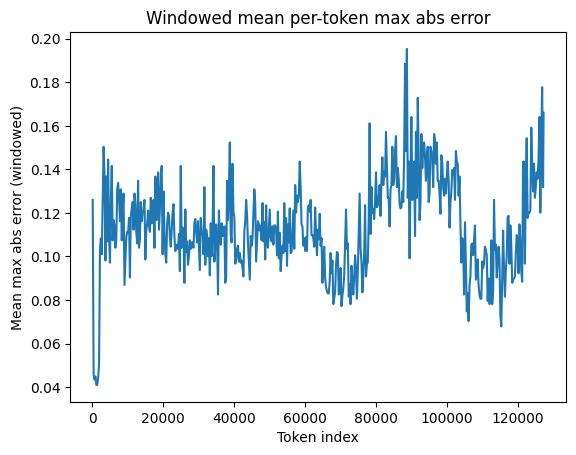

In [52]:
per_token_max = (abs(gt_k-dc_k).max(dim=-1).values.max(dim=-1)).values[0]
S = per_token_max.numel()
window = 256
means = []
centers = []

for start in range(0, S, window):
    end = min(start + window, S)
    m = per_token_max[start:end].mean().item()
    c = 0.5 * (start + end)
    centers.append(c)
    means.append(m)

plt.plot(centers, means)
plt.xlabel("Token index")
plt.ylabel("Mean max abs error (windowed)")
plt.title("Windowed mean per-token max abs error")

In [26]:
del gt_k, dc_k, gt_q, dc_q
torch.cuda.empty_cache()

# Logits analyze

In [19]:
gt_logits = torch.load('/home/ubuntu/projects/DiffCache/.data/logits.pt').view([152064])
logits = torch.load('/tmp/diffcache_prefix/Qwen/Qwen2.5-7B-Instruct/c20251117_161047/logits.pt').view([152064])

In [20]:
gt_logits.argmax()

tensor(2132, device='cuda:0')

In [21]:
logits.argmax()

tensor(21732, device='cuda:0')

In [6]:
del gt_logits, logits
torch.cuda.empty_cache()

# RoPE

In [57]:
bsz = 1
seq_len = 127284
head_dim = 128
num_kv_heads = 4
num_heads = 28

In [77]:
(gt_q, gt_k) = torch.load('/home/ubuntu/projects/DiffCache/.data/hidden_gt.pt')
gt_q = gt_q.view(bsz, seq_len, num_heads, head_dim)
gt_k = gt_k.view(bsz, seq_len, num_kv_heads, head_dim)
(q, k) = torch.load('/home/ubuntu/projects/DiffCache/.data/hid_diffcache_out.pt')
q = q.view(bsz, seq_len, num_heads, head_dim)
k = k.view(bsz, seq_len, num_kv_heads, head_dim)
gt_q_rot, gt_k_rot = torch.load('/home/ubuntu/projects/DiffCache/.data/gt.pt')
gt_q_rot = gt_q_rot.permute(0, 2, 1, 3).contiguous().view(bsz, seq_len, num_heads, head_dim)
gt_k_rot = gt_k_rot.permute(0, 2, 1, 3).contiguous().view(bsz, seq_len, num_kv_heads, head_dim)
q_rot, k_rot = torch.load('/home/ubuntu/projects/DiffCache/.data/diffcache_out.pt')
q_rot = q_rot.view(bsz, seq_len, num_heads, head_dim)
k_rot = k_rot.view(bsz, seq_len, num_kv_heads, head_dim)

In [71]:
hf_qwen = Qwen2ForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-7B-Instruct", 
    torch_dtype=torch.bfloat16,
    rope_scaling={
        "type": "yarn",
        "factor": 4.0,
        "original_max_position_embeddings": 32768,
    },
)
hf_rotary_emb = hf_qwen.model.rotary_emb
    
def apply_rotary_pos_emb(query_states, key_states, position_ids):
    cos, sin = hf_rotary_emb(key_states, position_ids)
    q_rot, k_rot = hf_apply_rotary_pos_emb(query_states, key_states, cos, sin, unsqueeze_dim=2)
    return q_rot, k_rot

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 85.08it/s]


In [79]:
(q_rot-gt_q_rot)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [ ]:
position_ids = torch.arange(seq_len).unsqueeze(0).cuda()
hf_q_rot, hf_k_rot = apply_rotary_pos_emb(gt_q, gt_k, position_ids)
abs(hf_q_rot - gt_q_rot).max(), abs(hf_k_rot - gt_k_rot).max()

(tensor(0., device='cuda:0', dtype=torch.bfloat16),
 tensor(0., device='cuda:0', dtype=torch.bfloat16))

In [76]:
position_ids = torch.arange(seq_len).unsqueeze(0).cuda()
hf_q_rot, hf_k_rot = apply_rotary_pos_emb(q, k, position_ids)
abs(hf_q_rot - gt_q_rot).max(), abs(hf_k_rot - gt_k_rot).max()

(tensor(0.7500, device='cuda:0', dtype=torch.bfloat16),
 tensor(2., device='cuda:0', dtype=torch.bfloat16))

In [91]:
gt = torch.load('/home/ubuntu/projects/DiffCache/.data/gt.pt')
dc = torch.load('/home/ubuntu/projects/DiffCache/.data/diffcache_out.pt')

In [92]:
gt.shape, dc.shape

(torch.Size([1, 127284, 3584]), torch.Size([1, 127284, 3584]))

In [93]:
(gt-dc).abs().max()

tensor(0., device='cuda:0', dtype=torch.bfloat16)